# Autoencoder for time series

Import libreries for build and run the model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.contrib.rnn import LSTMCell
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD


In [2]:
# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm = True, ratio_train = 0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]

In [3]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData('../data/UCRArchive_2018', 'ECG5000')

## Config time

In [4]:
config = dict()
config = dict()  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64
config['learning_rate'] = .005
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 20 # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8 # Dropout rate

Valuate sequence length

In [5]:
dataTrain.shape[0]
N = dataTrain.shape[0]
Nval = dataTest.shape[0]
D = dataTrain.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

We have 3999 observations with 140 dimensions


Valuate class number and min class

In [6]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 5 classes, 1.0 is the min class value


In [7]:
# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(X_train, y_train, plot_row=5, save = False, name = 'tmp.eps'):
    counts = dict(Counter(y_train))
    num_classes = len(np.unique(y_train))
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):  # Loops over classes, plot as columns
        c = int(c)
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            axarr[n, c].plot(X_train[ind_plot[n], :])
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, c].set_title('Class %.0f (%.0f)' % (c, counts[float(c)]))
            if not n == plot_row - 1:
                plt.setp([axarr[n, c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n, c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  # No horizontal space between subplots
    f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='eps', dpi=1000)
        
    return


Populating the interactive namespace from numpy and matplotlib


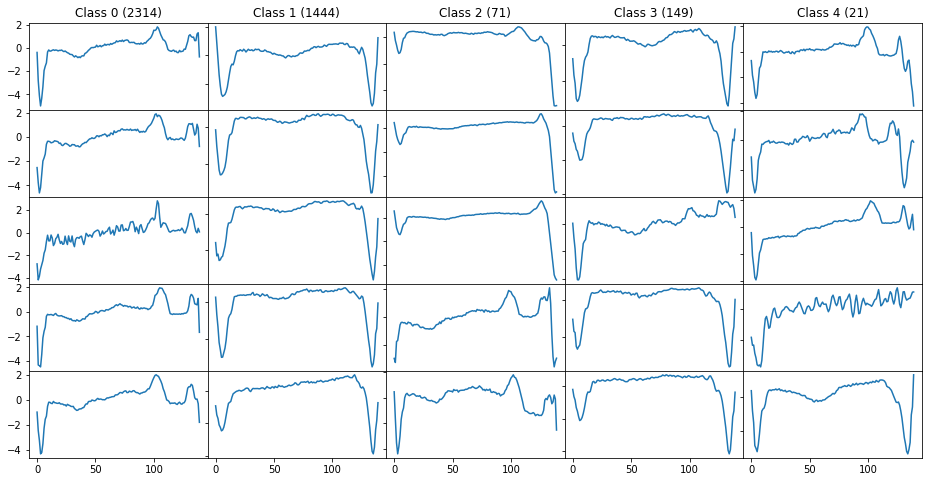

<Figure size 1152x576 with 0 Axes>

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

## Training time